In [1]:
import os

import scipy.io
import scanpy as sc
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt

# Prepare Anndata

In [2]:
dir_path = '/Users/Emrys/Dropbox/spatial_augmentation/data/liver_scrnaseq/NCI-CLARITY'

# Load data
matrix_path = os.path.join(dir_path, 'GSE151530_matrix.mtx')
genes_path = os.path.join(dir_path, 'GSE151530_genes.tsv')
barcodes_path = os.path.join(dir_path, 'GSE151530_barcodes.tsv')

matrix = scipy.io.mmread(matrix_path)
genes = pd.read_csv(genes_path, header=None, sep='\t')
barcodes = pd.read_csv(barcodes_path, header=None, sep='\t')

In [3]:
genes

,0,1
0,ENSG00000238009,RP11-34P13.7
1,ENSG00000279457,FO538757.2
2,ENSG00000228463,AP006222.2
3,ENSG00000237094,RP4-669L17.10
4,ENSG00000237491,RP11-206L10.9
...,...,...
18662,ENSG00000278817,AC007325.4
18663,ENSG00000277196,AC007325.2
18664,ENSG00000278384,AL354822.1
18665,ENSG00000276345,AC004556.1


In [4]:
duplicates = genes.duplicated(subset=[1], keep=False)  # Identifies all duplicates
num_duplicates = duplicates.sum()  # Counts the number of duplicates

print(f"Number of duplicate gene names: {num_duplicates}")

if num_duplicates > 0:
    print(genes[duplicates])

Number of duplicate gene names: 12
                     0         1
1408   ENSG00000143248      RGS5
1409   ENSG00000232995      RGS5
3553   ENSG00000114395  CYB561D2
3556   ENSG00000271858  CYB561D2
5481   ENSG00000280987     MATR3
5482   ENSG00000015479     MATR3
9114   ENSG00000225655  PGM5-AS1
9131   ENSG00000224958  PGM5-AS1
10782  ENSG00000216937     CCDC7
10783  ENSG00000150076     CCDC7
13135  ENSG00000273259  SERPINA3
13136  ENSG00000196136  SERPINA3


In [3]:
# Create AnnData object
adata = ad.AnnData(X=matrix.astype('float32').T.tocsr())
adata.var_names = genes[1]
adata.obs_names = barcodes[0]

# Load cell type annotations
annotations_path = os.path.join(dir_path, 'GSE151530_Info.txt')
annotations = pd.read_csv(annotations_path, sep='\t')
annotations.set_index('Cell', inplace=True)
adata.obs = adata.obs.merge(annotations, how='left', left_index=True, right_index=True, validate='one_to_one')

In [4]:
adata

AnnData object with n_obs × n_vars = 56721 × 18667
    obs: 'S_ID', 'Sample', 'Type'

In [27]:
# Convert the entire expression matrix to a DataFrame and transpose
expression_df = adata.to_df().T
expression_df['genes'] = expression_df.index
# Group by gene names (assuming gene names are in the index of `adata.var`)
mean_expression = expression_df.groupby('genes').mean()

In [34]:
mean_expression.shape

(18661, 56721)

In [35]:
# Create a new AnnData object without duplicates
adata_unique = ad.AnnData(X=scipy.sparse.csr_matrix(mean_expression.T), 
                          obs=adata.obs, 
                          var=pd.DataFrame(index=mean_expression.index))

adata_unique

AnnData object with n_obs × n_vars = 56721 × 18661
    obs: 'S_ID', 'Sample', 'Type'

In [38]:
adata_unique.write('/Users/Emrys/Dropbox/spatial_augmentation/data/liver_scrnaseq/NCI-CLARITY/liver_scrna.h5ad')

# Load AnnData

In [2]:
adata= ad.read_h5ad('/Users/Emrys/Dropbox/spatial_augmentation/data/liver_scrnaseq/NCI-CLARITY/liver_scrna.h5ad')

/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
adata.var

""
RP11-34P13.7
FO538757.2
AP006222.2
RP4-669L17.10
RP11-206L10.9
...
AC007325.4
AC007325.2
AL354822.1
AC004556.1


# Visualisation

/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/miniconda3/envs/mesa/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDepr

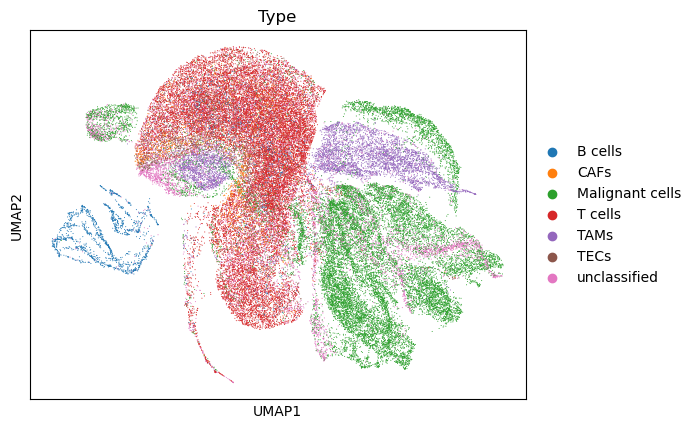

In [36]:
# PCA
sc.tl.pca(adata_unique, svd_solver='arpack')
sc.pp.neighbors(adata_unique, n_neighbors=10, n_pcs=50)

# UMAP
sc.tl.umap(adata_unique)  # or sc.tl.tsne(adata)

# Plotting the results
sc.pl.umap(adata_unique, color='Type')


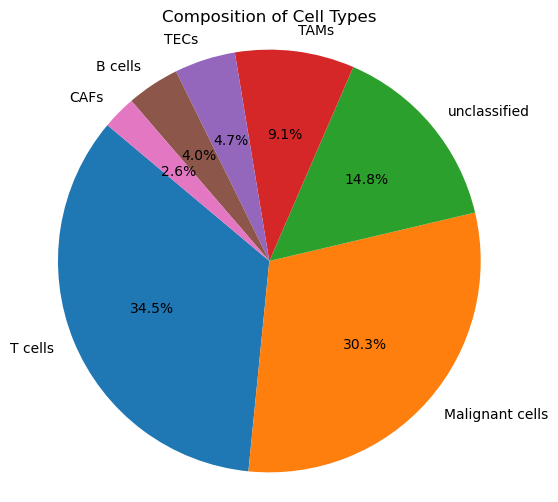

In [37]:
cell_type_counts = adata_unique.obs['Type'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(cell_type_counts, labels=cell_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Composition of Cell Types')
plt.show()